# 사전설정

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np

## 종목 설정

In [17]:
# 1. 설정
tickers = {
    'KODEX 코스닥150': '229200.KS',
    'KODEX 2차전지산업': '305720.KS',
    'TIGER 2차전지K-뉴딜': '364980.KS',
}

# 데이터 로드

In [18]:
# 지표 계산(60일 모멘텀, 50일 이평선)을 위해 2023년 하반기 데이터부터 다운로드
start_date = '2023-09-01'
end_date = '2024-12-31'
backtest_start_date = '2024-01-01'
initial_capital = 100000000 # 초기 자본금 1억원
momentum_window = 60 # 모멘텀 계산 기간 (거래일 기준)
ma_window = 50       # 이동평균선 계산 기간
k_value = 0.5        # 변동성 돌파 계수 (래리 윌리엄스 전략의 표준값)

In [19]:
# 2. 데이터 다운로드
try:
    # 시가, 고가, 저가, 종가 데이터 모두 필요 (auto_adjust=False로 Close 데이터 사용)
    raw_data = yf.download(list(tickers.values()), start=start_date, end=end_date, progress=False, auto_adjust=False)
    
    # 한국 ETF는 Adj Close가 없으므로 Close 사용
    data = pd.DataFrame()
    for price_type in ['Open', 'High', 'Low', 'Close']:
        if price_type in raw_data.columns.get_level_values(0):
            for ticker_code in tickers.values():
                ticker_name = [k for k, v in tickers.items() if v == ticker_code][0]
                data[(price_type, ticker_name)] = raw_data[price_type][ticker_code]
    
    # MultiIndex 컬럼 명시적으로 설정
    data.columns = pd.MultiIndex.from_tuples(data.columns)
    data = data.ffill()
    
    print("데이터 다운로드 성공!")
    print(f"데이터 형태: {data.shape}")
    print(f"\n최근 5행:\n{data.tail()}")
    
except Exception as e:
    import traceback
    print(f"데이터 다운로드 중 오류 발생: {e}")
    traceback.print_exc()

데이터 다운로드 성공!
데이터 형태: (319, 12)

최근 5행:
                   Open                                     High               \
           KODEX 코스닥150 KODEX 2차전지산업 TIGER 2차전지K-뉴딜 KODEX 코스닥150 KODEX 2차전지산업   
Date                                                                            
2024-12-23      11110.0      12640.0         8610.0      11285.0      12715.0   
2024-12-24      11205.0      12705.0         8700.0      11270.0      12875.0   
2024-12-26      11300.0      12545.0         8585.0      11300.0      12550.0   
2024-12-27      11165.0      12110.0         8340.0      11260.0      12320.0   
2024-12-30      11010.0      12060.0         8340.0      11335.0      12385.0   

                                   Low                              \
           TIGER 2차전지K-뉴딜 KODEX 코스닥150 KODEX 2차전지산업 TIGER 2차전지K-뉴딜   
Date                                                                 
2024-12-23         8695.0      11000.0      12250.0         8370.0   
2024-12-24         8795.0      1

# 백테스트 수행

## 전략 검증 포인트
- ✅ **투자 유니버스**: 고변동성 섹터 ETF 3종 (코스닥150, 2차전지산업, 2차전지K-뉴딜)
- ✅ **종목 선정**: 매주 첫 거래일에 60일 수익률 1위 ETF 선정
- ✅ **진입 신호**: 변동성 돌파 - 당일 고가 ≥ 시가 + (전일 고가-저가) × 0.5
- ✅ **청산 신호**: 당일 종가 < 50일 이동평균선
- ✅ **투자 방식**: 선정된 단일 ETF에 100% 집중 투자
- ✅ **리밸런싱**: 매주 월요일(첫 거래일) 종목 재선정
- ✅ **포지션 유지**: 상승 추세 유지 시 주중 보유, 50일선 하회 시 즉시 청산

In [20]:
# 3. 백테스트 시뮬레이션
backtest_data = data.loc[backtest_start_date:].copy()

# 포트폴리오 상태 변수 초기화
cash = initial_capital
position = None # 보유 종목 티커
shares = 0      # 보유 수량
portfolio_history = pd.Series(index=backtest_data.index, dtype=float)
target_etf = None # 이번 주에 공략할 ETF

# 매주 첫 거래일(리밸런싱일) 목록 생성
weekly_rebal_dates = backtest_data.resample('W-MON').first().index

# 일별 루프 실행
for i in range(len(backtest_data)):
    date = backtest_data.index[i]
    
    # --- 1. 매주 첫 거래일: 투자 대상 선정 ---
    if date in weekly_rebal_dates:
        # (1) 기존 포지션이 있다면 청산 (매주 새로운 기준으로 시작)
        if position:
            # 전일 종가 기준으로 현금화
            prev_close = data.loc[backtest_data.index[i-1], ('Close', position)]
            cash = shares * prev_close
            position = None
            shares = 0
            print(f"{date.date()}: 주간 리밸런싱. 기존 포지션 청산. 현금: {int(cash):,}원")

        # (2) 새로운 투자 대상 선정 (과거 60일 수익률 1위)
        hist_data_for_mom = data.loc[:date].tail(momentum_window + 1)
        if len(hist_data_for_mom) < momentum_window + 1:
            print(f"{date.date()}: 모멘텀 계산을 위한 데이터 부족. 건너뜀")
            continue
        
        # 오늘 포함 60일 전 가격 대비 현재 종가 수익률
        close_prices_now = hist_data_for_mom.iloc[-1].loc['Close']
        close_prices_past = hist_data_for_mom.iloc[0].loc['Close']
        returns_60d = (close_prices_now / close_prices_past) - 1
        target_etf = returns_60d.idxmax() # 수익률이 가장 높은 ETF 이름
        
        print(f"{date.date()}: [주간 리밸런싱]")
        print(f"    60일 수익률: {dict((k, f'{v*100:.2f}%') for k, v in returns_60d.items())}")
        print(f"    ✅ 이번 주 투자 대상: {target_etf} ({returns_60d[target_etf]*100:.2f}%)")
    
    # --- 2. 매일: 매매 신호에 따라 거래 실행 ---
    if target_etf: # 이번 주 투자 대상이 선정되었다면
        
        # (1) 청산 신호 확인 (보유 중일 때만)
        if position == target_etf:
            ma50_data = data.loc[:date, ('Close', target_etf)].tail(ma_window)
            if len(ma50_data) >= ma_window:
                ma50 = ma50_data.mean()
                current_close = backtest_data.loc[date, ('Close', target_etf)]
                if current_close < ma50:
                    cash = shares * current_close # 종가에 매도
                    print(f"{date.date()}: [매도] {target_etf} at {int(current_close):,}원. 50일선({int(ma50):,}원) 하회. 현금: {int(cash):,}원")
                    position = None
                    shares = 0
        
        # (2) 진입 신호 확인 (보유 중이 아닐 때만)
        elif position is None and i > 0:
            # 전일 데이터 가져오기
            prev_day_data = data.loc[backtest_data.index[i-1]]
            prev_high = prev_day_data[('High', target_etf)]
            prev_low = prev_day_data[('Low', target_etf)]
            
            # 변동성 돌파 가격 계산
            volatility_range = prev_high - prev_low
            today_open = backtest_data.loc[date, ('Open', target_etf)]
            entry_price = today_open + (volatility_range * k_value)
            
            # 오늘 고가가 진입 가격을 돌파했는지 확인
            today_high = backtest_data.loc[date, ('High', target_etf)]
            if today_high >= entry_price:
                # 매수 실행 (진입 가격에 체결되었다고 가정)
                shares = cash / entry_price
                position = target_etf
                cash = 0
                print(f"{date.date()}: [매수] {target_etf} at {int(entry_price):,}원. 변동성 돌파 (Range: {int(volatility_range):,}원). 수량: {shares:.2f}주")

    # --- 3. 매일: 포트폴리오 가치 기록 ---
    if position:
        # 포지션을 보유한 경우: (보유수량 * 현재 종가)로 자산가치 계산
        current_close = backtest_data.loc[date, ('Close', position)]
        portfolio_value = shares * current_close
    else:
        # 포지션이 없는 경우: 현금 가치
        portfolio_value = cash
    
    portfolio_history[date] = portfolio_value

2024-01-08: [주간 리밸런싱]
    60일 수익률: {'KODEX 코스닥150': '8.34%', 'KODEX 2차전지산업': '-4.36%', 'TIGER 2차전지K-뉴딜': '-8.67%'}
    ✅ 이번 주 투자 대상: KODEX 코스닥150 (8.34%)
2024-01-09: [매수] KODEX 코스닥150 at 14,155원. 변동성 돌파 (Range: 210원). 수량: 7064.64주
2024-01-15: 주간 리밸런싱. 기존 포지션 청산. 현금: 96,679,618원
2024-01-15: [주간 리밸런싱]
    60일 수익률: {'KODEX 코스닥150': '5.77%', 'KODEX 2차전지산업': '-9.41%', 'TIGER 2차전지K-뉴딜': '-13.15%'}
    ✅ 이번 주 투자 대상: KODEX 코스닥150 (5.77%)
2024-01-22: [주간 리밸런싱]
    60일 수익률: {'KODEX 코스닥150': '3.45%', 'KODEX 2차전지산업': '-14.59%', 'TIGER 2차전지K-뉴딜': '-17.59%'}
    ✅ 이번 주 투자 대상: KODEX 코스닥150 (3.45%)
2024-01-23: [매수] KODEX 코스닥150 at 13,032원. 변동성 돌파 (Range: 325원). 수량: 7418.35주
2024-01-24: [매도] KODEX 코스닥150 at 12,830원. 50일선(13,257원) 하회. 현금: 95,177,403원
2024-01-26: [매수] KODEX 코스닥150 at 12,610원. 변동성 돌파 (Range: 200원). 수량: 7547.77주
2024-01-29: 주간 리밸런싱. 기존 포지션 청산. 현금: 97,970,078원
2024-01-29: [주간 리밸런싱]
    60일 수익률: {'KODEX 코스닥150': '11.14%', 'KODEX 2차전지산업': '-0.26%', 'TIGER 2차전지K-뉴딜': '-1.30%'}
    ✅ 이번 주 투자 대상

# 성과분석

In [21]:
# 4. 성과 분석
portfolio_df = portfolio_history.dropna().to_frame('Portfolio')
portfolio_df['Daily_Return'] = portfolio_df['Portfolio'].pct_change()

final_value = portfolio_df['Portfolio'].iloc[-1]
cagr = ((final_value / initial_capital) ** (365.0 / len(portfolio_df))) - 1

rolling_max = portfolio_df['Portfolio'].cummax()
daily_drawdown = portfolio_df['Portfolio'] / rolling_max - 1.0
mdd = daily_drawdown.min()

sharpe_ratio = portfolio_df['Daily_Return'].mean() / portfolio_df['Daily_Return'].std() * np.sqrt(252)

print("\n--- 최종 백테스트 결과 ---")
print(f"초기 자산: {initial_capital:,.0f} 원")
print(f"최종 자산: {final_value:,.0f} 원")
print(f"CAGR (연율화 수익률): {cagr:.2%}")
print(f"MDD (최대 낙폭): {mdd:.2%}")
print(f"Sharpe Ratio (샤프 지수): {sharpe_ratio:.2f}\n")


--- 최종 백테스트 결과 ---
초기 자산: 100,000,000 원
최종 자산: 69,237,551 원
CAGR (연율화 수익률): -42.83%
MDD (최대 낙폭): -38.45%
Sharpe Ratio (샤프 지수): -1.79



# 성과 시각화

In [22]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 포트폴리오 가치 추이

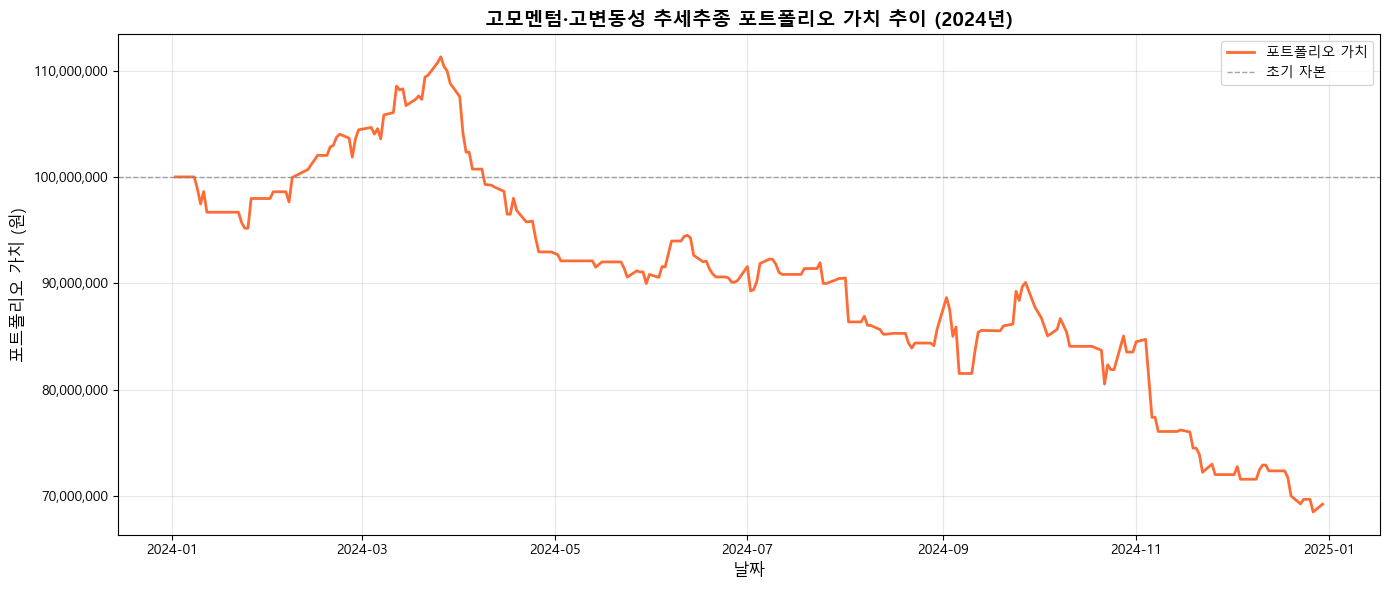

In [23]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(portfolio_df.index, portfolio_df['Portfolio'], linewidth=2, color='#FF6B35', label='포트폴리오 가치')
ax.axhline(y=initial_capital, color='gray', linestyle='--', linewidth=1, alpha=0.7, label='초기 자본')

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('포트폴리오 가치 (원)', fontsize=12)
ax.set_title('고모멘텀·고변동성 추세추종 포트폴리오 가치 추이 (2024년)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

## 2. 누적 수익률 추이

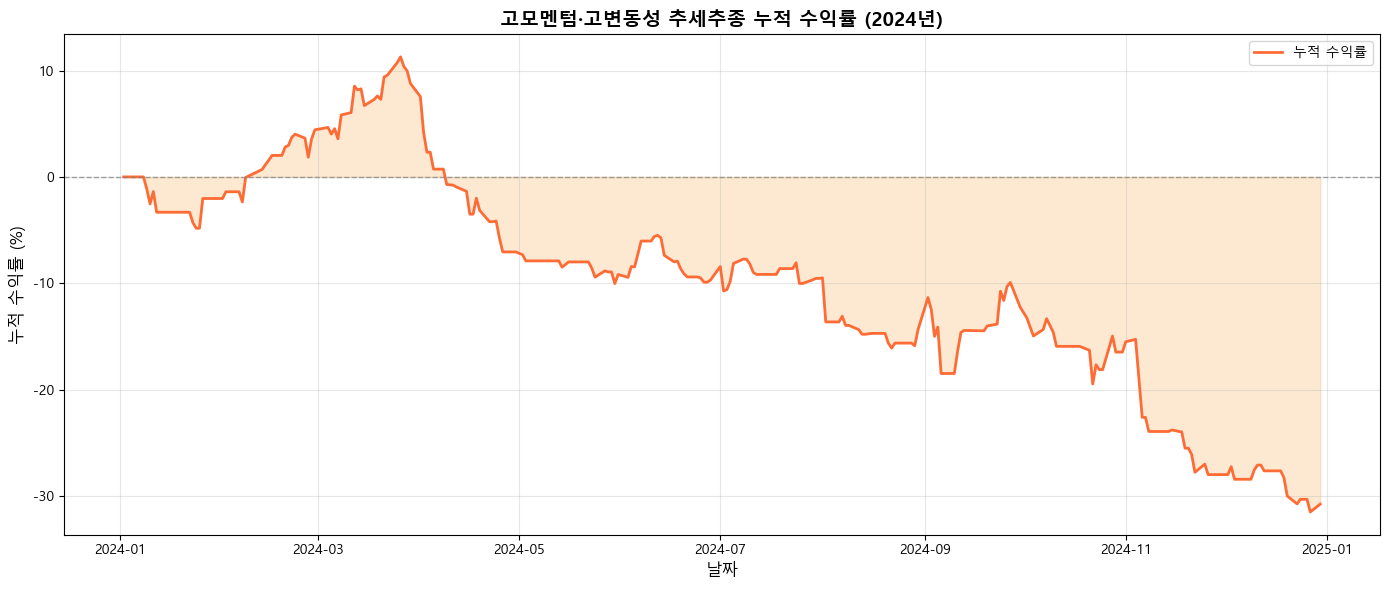

In [24]:
fig, ax = plt.subplots(figsize=(14, 6))

cumulative_return = (portfolio_df['Portfolio'] / initial_capital - 1) * 100

ax.plot(portfolio_df.index, cumulative_return, linewidth=2, color='#FF6B35', label='누적 수익률')
ax.fill_between(portfolio_df.index, cumulative_return, 0, alpha=0.2, color='#F7931E')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('누적 수익률 (%)', fontsize=12)
ax.set_title('고모멘텀·고변동성 추세추종 누적 수익률 (2024년)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. 낙폭(Drawdown) 분석

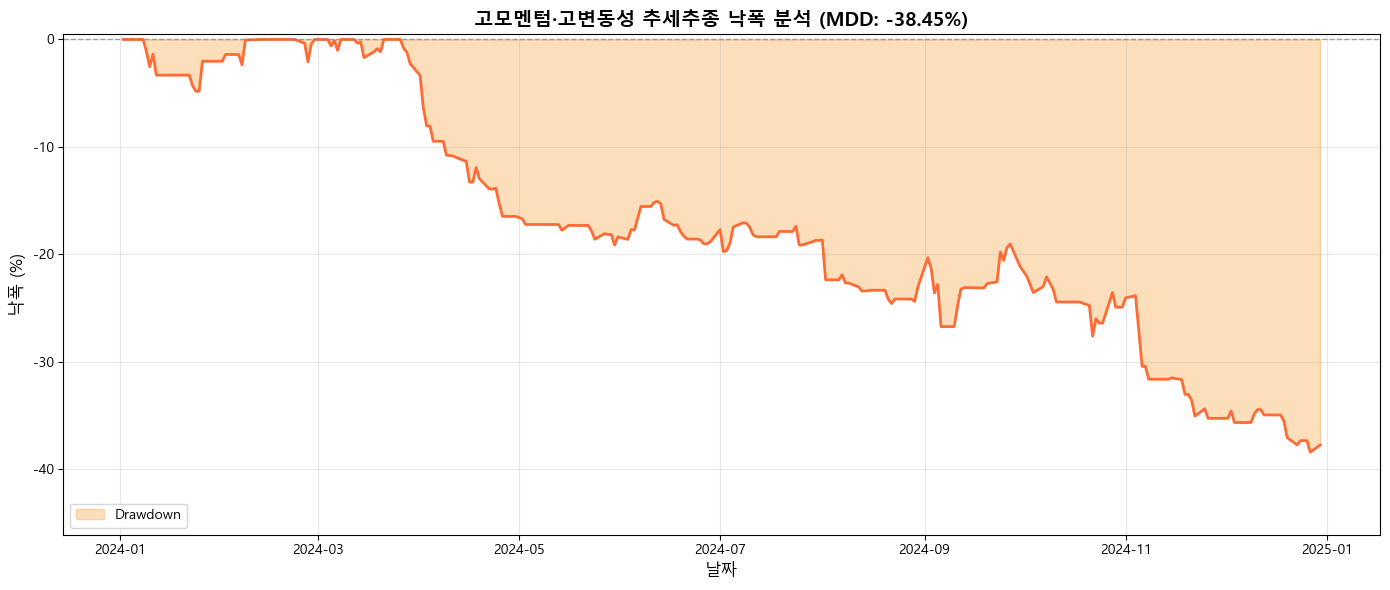

In [25]:
fig, ax = plt.subplots(figsize=(14, 6))

drawdown_pct = daily_drawdown * 100

ax.fill_between(portfolio_df.index, drawdown_pct, 0, alpha=0.3, color='#F7931E', label='Drawdown')
ax.plot(portfolio_df.index, drawdown_pct, linewidth=2, color='#FF6B35')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

y_min = min(drawdown_pct.min() * 1.2, -1)
ax.set_ylim(y_min, 0.5)

ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('낙폭 (%)', fontsize=12)
ax.set_title(f'고모멘텀·고변동성 추세추종 낙폭 분석 (MDD: {mdd:.2%})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. 일별 수익률 분포

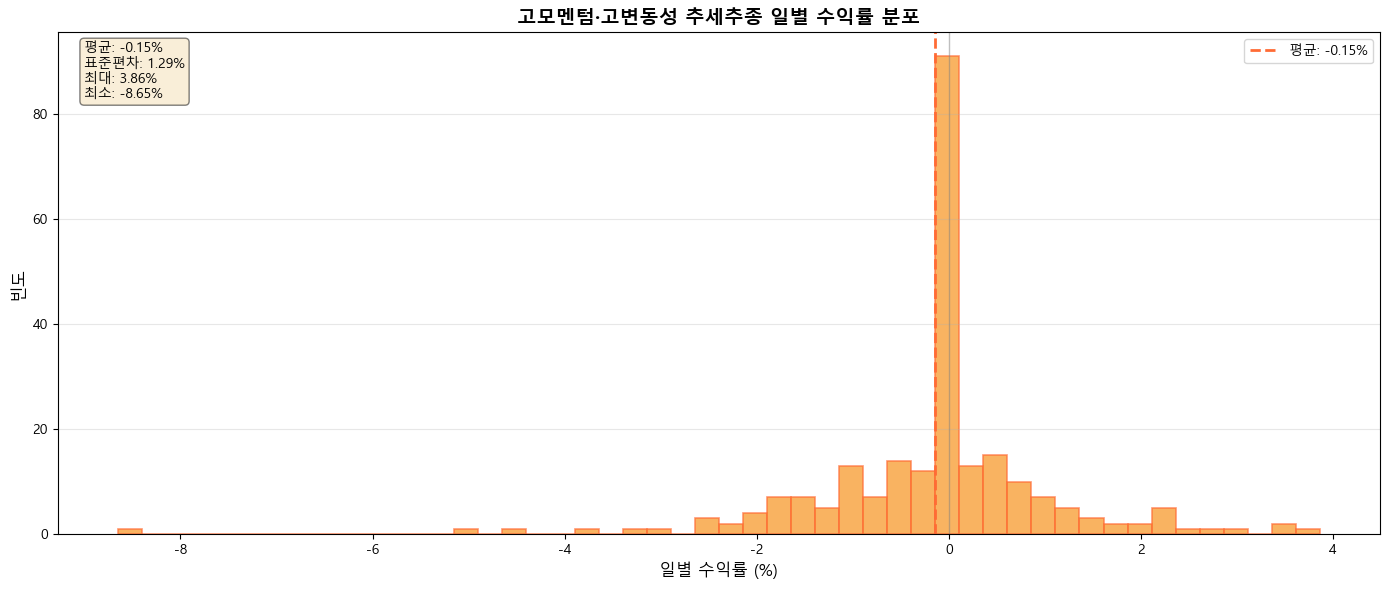

In [26]:
fig, ax = plt.subplots(figsize=(14, 6))

daily_returns_pct = portfolio_df['Daily_Return'].dropna() * 100

ax.hist(daily_returns_pct, bins=50, alpha=0.7, color='#F7931E', edgecolor='#FF6B35', linewidth=1.2)
ax.axvline(x=daily_returns_pct.mean(), color='#FF6B35', linestyle='--', linewidth=2, label=f'평균: {daily_returns_pct.mean():.2f}%')
ax.axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

ax.set_xlabel('일별 수익률 (%)', fontsize=12)
ax.set_ylabel('빈도', fontsize=12)
ax.set_title('고모멘텀·고변동성 추세추종 일별 수익률 분포', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 통계량 표시
textstr = f'평균: {daily_returns_pct.mean():.2f}%\n표준편차: {daily_returns_pct.std():.2f}%\n최대: {daily_returns_pct.max():.2f}%\n최소: {daily_returns_pct.min():.2f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

## 5. 월별 수익률

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_30012\160849111.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = portfolio_df['Portfolio'].resample('M').last().pct_change().dropna() * 100


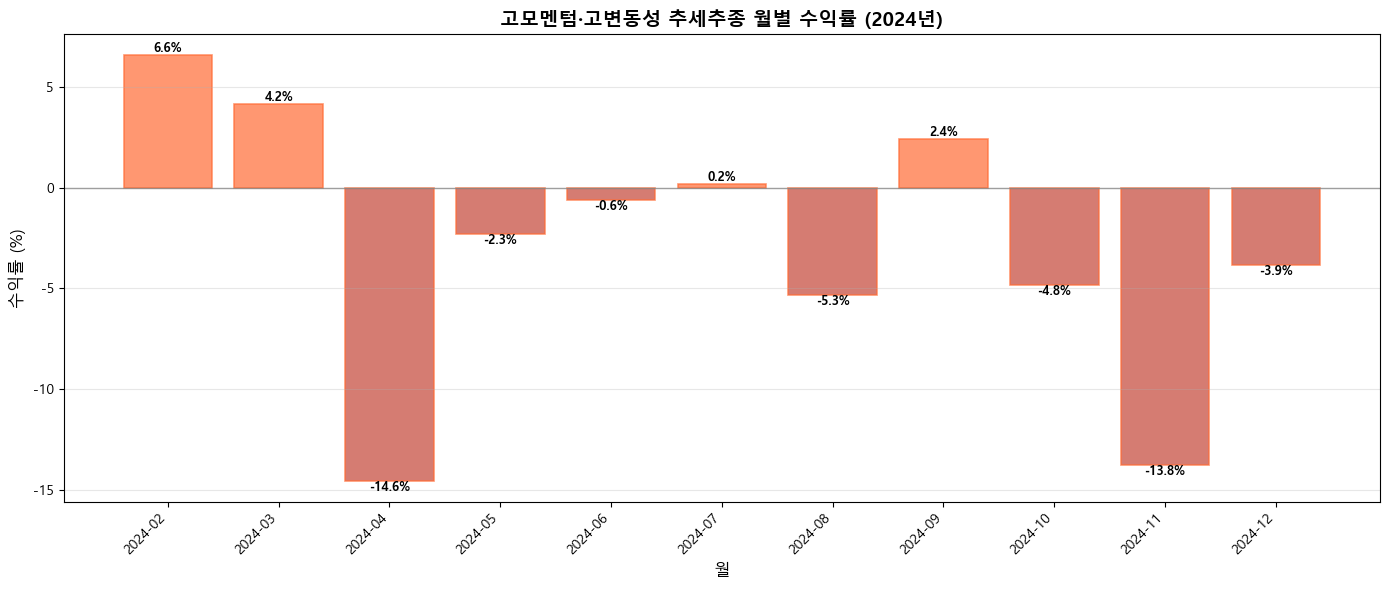

In [27]:
monthly_returns = portfolio_df['Portfolio'].resample('M').last().pct_change().dropna() * 100

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#FF6B35' if x >= 0 else '#C44536' for x in monthly_returns]
bars = ax.bar(range(len(monthly_returns)), monthly_returns, color=colors, alpha=0.7, edgecolor='#FF6B35', linewidth=1.2)

ax.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.7)
ax.set_xlabel('월', fontsize=12)
ax.set_ylabel('수익률 (%)', fontsize=12)
ax.set_title('고모멘텀·고변동성 추세추종 월별 수익률 (2024년)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(monthly_returns)))
ax.set_xticklabels([d.strftime('%Y-%m') for d in monthly_returns.index], rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# 막대 위에 값 표시
for i, (bar, value) in enumerate(zip(bars, monthly_returns)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f}%',
            ha='center', va='bottom' if height > 0 else 'top',
            fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()